In [776]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math

In [777]:
def analytical_a(CT):
    # note that CT is actually CT'
    return CT / (4 + CT)

def a_to_Cp(a, alg = "classical"):
    return 4 * a * (1 - a)**2

def johlas(cp, sa, pa):
    v = 0
    if sa != 0:  # surging
        v = sa  # why doesn't this depend on f?
    else:  # pitching
        v = 0#np.sin(np.deg2rad(pa))
    x_disp = (1 + (3 * (v**2)) / 2)
    theta_disp = np.mean([np.cos(np.deg2rad(pa) * np.sin(x))**3 for x in np.linspace(0, 2 * np.pi, 250)])
    return cp * x_disp * theta_disp

In [778]:
(1 + (3 * (np.sin(np.deg2rad(3))**2)) / 2), np.mean([np.cos(np.deg2rad(3) * np.sin(x))**3 for x in np.linspace(0, 2 * np.pi, 250)])

(np.float64(1.004108578473795), np.float64(0.997954511823681))

In [779]:
def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

df = pd.read_csv("/Users/sky/src/HowlandLab/data/initial_moving_analysis.csv")
df = df.dropna()

In [780]:
df['Movement'] = df.apply(lambda row: ("Stationary" if row.marker == "o" else ("Surging" if row.marker == "s" else "Pitching")), axis = 1)
df = df[df.nx == 256]  # only keep 256 x 128 x 128 simulations
df = df[df.filterFactor == 1.5]
df = df[df.useCorrection]

cols_to_keep = ["Movement", "nx", "filterFactor", "filterFactor", "useCorrection", "turbulence", "CT_prime", "surge_freq", "surge_amplitude", "pitch_amplitude"]
df = df.drop_duplicates(subset = cols_to_keep, keep = 'last')

In [781]:
max_motion_df = df[df["surge_freq"] == 1]
max_motion_df = max_motion_df[(max_motion_df["surge_amplitude"] == 0.5) | (max_motion_df["pitch_amplitude"] == 5)]

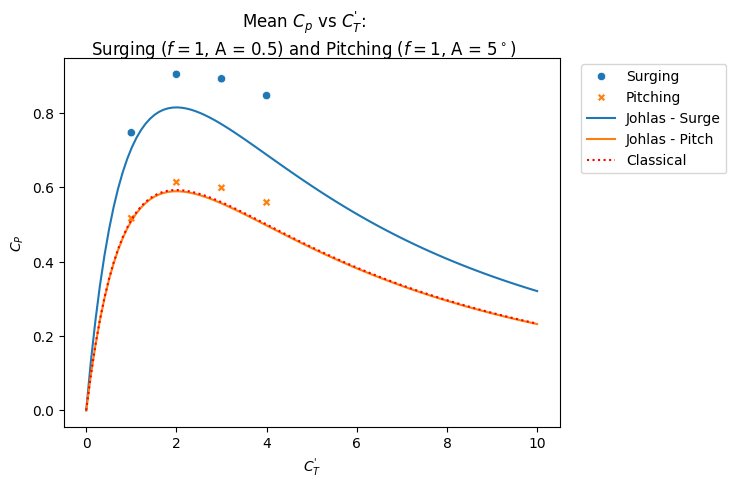

In [782]:
fig, ax = plt.subplots(1, 1)
fig.suptitle("Mean $C_p$ vs $C_T^'$:\nSurging ($f = 1$, A = $0.5$) and Pitching ($f = 1$, A = $5^\circ$)")
ax.set_xlabel('$C_T^\'$')
ax.set_ylabel('$C_P$')
palette =['tab:blue', 'tab:orange']
sns.scatterplot(data = max_motion_df, x = "CT_prime", y = "mean_Cp", hue = "Movement", style = "Movement", palette = palette)

ctp_list = np.linspace(0, 10, num = 100)
classical_cp = [a_to_Cp(analytical_a(ctp)) for ctp in ctp_list]
johlas_surge = [johlas(cp, 0.5, 0.0) for cp in classical_cp]
johlas_pitch = [johlas(cp, 0.0, 5.0) for cp in classical_cp]
sns.lineplot(x = ctp_list, y = johlas_surge, color = palette[0], label = "Johlas - Surge")
sns.lineplot(x = ctp_list, y = johlas_pitch, color = palette[1], label = "Johlas - Pitch")
sns.lineplot(x = ctp_list, y = classical_cp, color = 'k', linestyle=':', label = "Classical")

leg = ax.legend()
bb = leg.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
xOffset = 0.35
bb.x0 += xOffset
bb.x1 += xOffset
leg = leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

In [783]:
ct1_df = df[(df["CT_prime"] == 1) & (df["surge_freq"] != 0)]
ct1_df["amp"] = ct1_df.apply((lambda row: np.maximum(row.surge_amplitude, row.pitch_amplitude)), axis = 1)

classical_cp = a_to_Cp(analytical_a(1.0))
ct1_df["normalized_mean_cp"] = ct1_df.apply((lambda row: row.mean_Cp / classical_cp), axis = 1)
ct1_df["percent_diff_classical"] = ct1_df.apply((lambda row: 100 * (row.mean_Cp - classical_cp) / classical_cp), axis = 1)

surge_df = ct1_df[ct1_df["Movement"] == "Surging"]
pitch_df = ct1_df[ct1_df["Movement"] == "Pitching"]

/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_85499/2257410152.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ct1_df["amp"] = ct1_df.apply((lambda row: np.maximum(row.surge_amplitude, row.pitch_amplitude)), axis = 1)
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_85499/2257410152.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ct1_df["normalized_mean_cp"] = ct1_df.apply((lambda row: row.mean_Cp / classical_cp), axis = 1)
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipyk

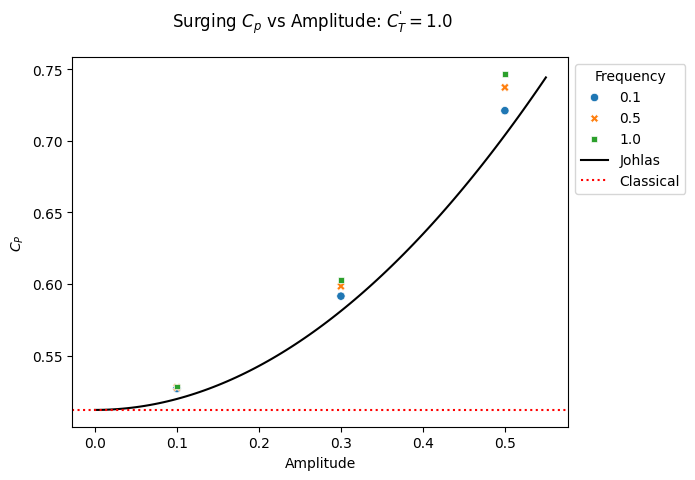

In [784]:
fig, ax = plt.subplots(1, 1)
fig.suptitle("Surging $C_p$ vs Amplitude: $C_T^\' = 1.0$")
ax.set_xlabel('Amplitude')
ax.set_ylabel('$C_P$')

palette =['tab:blue', 'tab:orange', 'tab:green']

sns.scatterplot(data = surge_df, x = "amp", y = "mean_Cp", hue = "surge_freq", style = "surge_freq", palette = palette)

amp = np.linspace(0, 0.55, num = 100)
johlas_surge = [johlas(classical_cp, a, 0.0) for a in amp]
sns.lineplot(x = amp, y = johlas_surge, color = 'k', label = "Johlas")
ax.axhline(y = classical_cp, color = 'r', linestyle=':', label = "Classical")

leg = ax.legend(title = "Frequency")
bb = leg.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
xOffset = 0.25
bb.x0 += xOffset
bb.x1 += xOffset
leg = leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

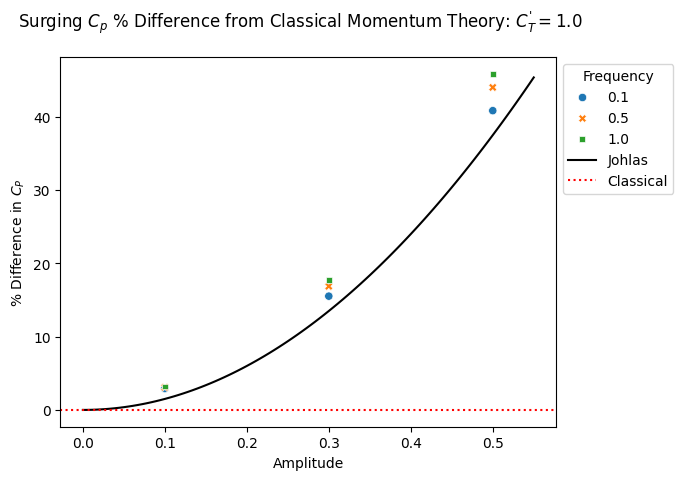

In [785]:
fig, ax = plt.subplots(1, 1)
fig.suptitle("Surging $C_p$ % Difference from Classical Momentum Theory: $C_T^\' = 1.0$")
ax.set_xlabel('Amplitude')
ax.set_ylabel('% Difference in $C_P$')

palette =['tab:blue', 'tab:orange', 'tab:green']

sns.scatterplot(data = surge_df, x = "amp", y = "percent_diff_classical", hue = "surge_freq", style = "surge_freq", palette = palette)

amp = np.linspace(0, 0.55, num = 100)
johlas_surge = [(100 * (johlas(classical_cp, a, 0.0) - classical_cp) / classical_cp) for a in amp]
sns.lineplot(x = amp, y = johlas_surge, color = 'k', label = "Johlas")
ax.axhline(y = 0, color = 'r', linestyle=':', label = "Classical")

leg = ax.legend(title = "Frequency")
bb = leg.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
xOffset = 0.25
bb.x0 += xOffset
bb.x1 += xOffset
leg = leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

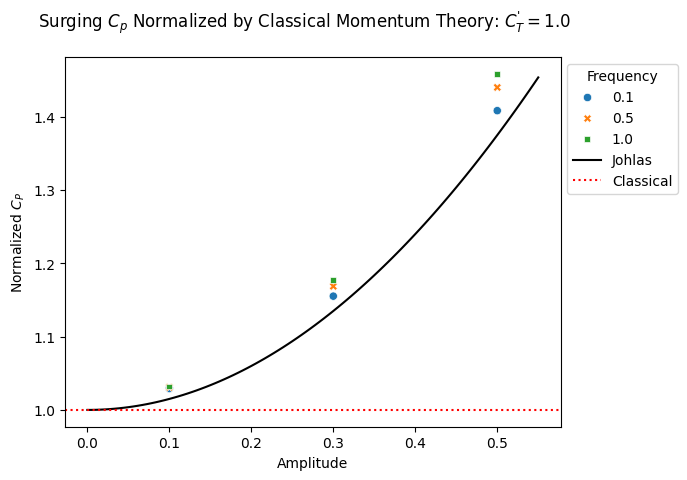

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.suptitle("Surging $C_p$ Normalized by Classical Momentum Theory: $C_T^\' = 1.0$")
ax.set_xlabel('Amplitude')
ax.set_ylabel('Normalized $C_P$')

palette =['tab:blue', 'tab:orange', 'tab:green']

sns.scatterplot(data = surge_df, x = "amp", y = "normalized_mean_cp", hue = "surge_freq", style = "surge_freq", palette = palette)

amp = np.linspace(0, 0.55, num = 100)
johlas_surge = [(johlas(classical_cp, a, 0.0) / classical_cp) for a in amp]
sns.lineplot(x = amp, y = johlas_surge, color = 'k', label = "Johlas")
ax.axhline(y = 1, color = 'r', linestyle=':', label = "Classical")

leg = ax.legend(title = "Frequency")
bb = leg.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
xOffset = 0.25
bb.x0 += xOffset
bb.x1 += xOffset
leg = leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

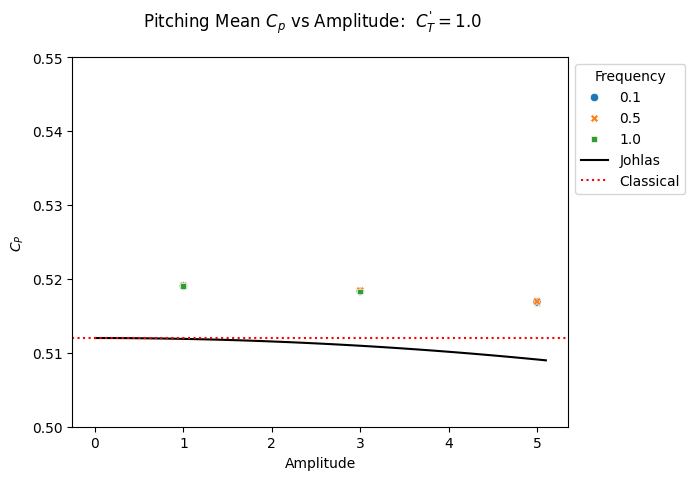

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.suptitle("Pitching Mean $C_p$ vs Amplitude:  $C_T^\' = 1.0$")
ax.set_xlabel('Amplitude')
ax.set_ylabel('$C_P$')
ax.set_ylim(0.5, 0.55)

palette =['tab:blue', 'tab:orange', 'tab:green']
sns.scatterplot(data = pitch_df, x = "amp", y = "mean_Cp", hue = "surge_freq", style = "surge_freq", palette = palette)

amp = np.linspace(0, 5.1, num = 100)
johlas_pitch = [johlas(classical_cp, 0.0, a) for a in amp]
sns.lineplot(x = amp, y = johlas_pitch, color = 'k', label = "Johlas")
ax.axhline(y = classical_cp, color = 'r', linestyle=':', label = "Classical")

leg = ax.legend(title = "Frequency")
bb = leg.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
xOffset = 0.25
bb.x0 += xOffset
bb.x1 += xOffset
leg = leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

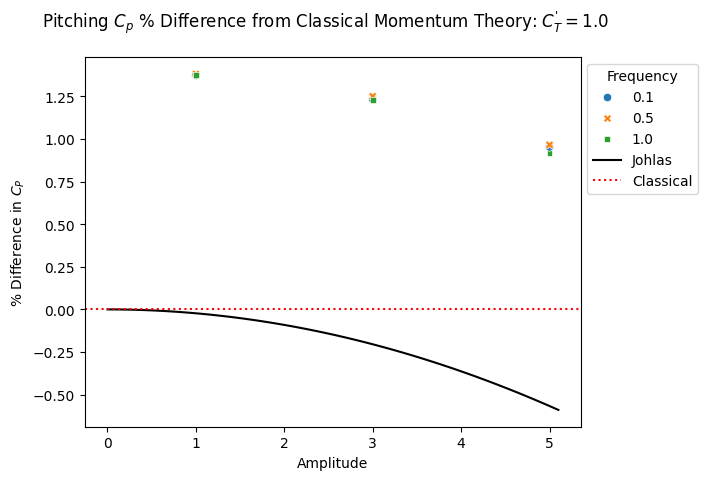

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.suptitle("Pitching $C_p$ % Difference from Classical Momentum Theory: $C_T^\' = 1.0$")
ax.set_xlabel('Amplitude')
ax.set_ylabel('% Difference in $C_P$')

palette =['tab:blue', 'tab:orange', 'tab:green']
sns.scatterplot(data = pitch_df, x = "amp", y = "percent_diff_classical", hue = "surge_freq", style = "surge_freq", palette = palette)

amp = np.linspace(0, 5.1, num = 100)
johlas_pitch = [100 * (johlas(classical_cp, 0.0, a) - classical_cp) / classical_cp for a in amp]
sns.lineplot(x = amp, y = johlas_pitch, color = 'k', label = "Johlas")
ax.axhline(y = 0, color = 'r', linestyle=':', label = "Classical")

leg = ax.legend(title = "Frequency")
bb = leg.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
xOffset = 0.25
bb.x0 += xOffset
bb.x1 += xOffset
leg = leg.set_bbox_to_anchor(bb, transform = ax.transAxes)